# Human vs. Animal Movement Classification

This notebook loads sensor data from `human_data.txt` and `animal_data.txt`, parses the JSON, extracts meaningful features, and builds a machine learning model to classify movement as either **human (0)** or **animal (1)**.

## Step 1: Load Dependencies

First, we'll import all the necessary libraries for data loading, processing, machine learning, and visualization.

In [17]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Step 2: Load and Parse Data

We need to read the `.txt` files. These files have a few header lines before the actual JSON data begins. We'll write a function that can safely parse these files, find the `=== BEGIN DATA STREAM ===` marker, and read all the JSON lines until the `=== END DATA STREAM ===` marker.

In [18]:
def parse_data_file(filename):
    """Reads a data file, skipping headers and parsing JSON lines."""
    # Check if the file exists first
    if not os.path.exists(filename):
        print(f"Warning: File not found - {filename}. Make sure it's in the same directory. Skipping.")
        return []
    
    data = []
    in_data_stream = False
    with open(filename, 'r') as f:
        for line in f:
            # Clean up potential escape characters if any
            line = line.strip().replace('\\\\', '\\')
            
            if line == '=== BEGIN DATA STREAM ===':
                in_data_stream = True
                continue
            if line == '=== END DATA STREAM ===':
                in_data_stream = False
                continue
            
            # Only process lines that start with '{' and are in the stream
            if in_data_stream and line.startswith('{'):
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    print(f"Warning: Could not parse line in {filename}: {line}")
    return data

In [19]:
# Define filenames
human_data_file = '../data/data_human.txt'
animal_data_file = '../data/data_animal.txt'

# Load data from both files
human_data = parse_data_file(human_data_file)
animal_data = parse_data_file(animal_data_file)

# Combine all data into one list
all_data = human_data + animal_data

print(f"Loaded {len(human_data)} human data samples.")
print(f"Loaded {len(animal_data)} animal data samples.")
print(f"Total samples: {len(all_data)}")

if all_data:
    print("\nFirst sample (from combined list):")
    print(json.dumps(all_data[0], indent=2))
else:
    print("\nError: No data was loaded. Please create 'human_data.txt' and 'animal_data.txt'.")

Loaded 250 human data samples.
Loaded 250 animal data samples.
Total samples: 500

First sample (from combined list):
{
  "sample": 1,
  "timestamp": 7142,
  "label": 0,
  "doppler": {
    "speed": 0.0,
    "range": 0.0,
    "energy": 0.0
  },
  "thermal": [
    21.75,
    21.25,
    21.25,
    21.75,
    21.0,
    21.0,
    20.75,
    20.5,
    20.75,
    21.0,
    21.0,
    21.75,
    20.5,
    20.75,
    20.75,
    21.5,
    21.5,
    21.25,
    20.75,
    20.75,
    20.25,
    20.75,
    20.75,
    20.75,
    21.25,
    20.75,
    20.0,
    21.25,
    20.25,
    20.5,
    21.25,
    21.25,
    21.25,
    20.75,
    20.75,
    22.75,
    20.5,
    21.25,
    21.25,
    21.5,
    21.0,
    22.0,
    21.5,
    22.5,
    21.25,
    21.5,
    21.25,
    21.25,
    21.75,
    21.75,
    22.25,
    22.0,
    21.5,
    21.75,
    21.5,
    21.25,
    22.25,
    22.5,
    22.0,
    22.75,
    21.25,
    21.75,
    21.75,
    21.75
  ],
  "mic": {
    "rms_mean": 0.0007,
    "peak_mean": 950

## Step 2.5: Exploratory Data Visualization (EDA)

Now that we have our data loaded into the `all_data` list, let's visualize it to find patterns and differences between human (0) and animal (1) movements.

First, we'll create a simple DataFrame for plotting basic distributions.

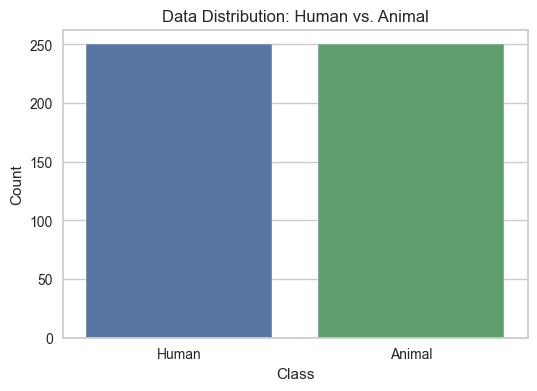

In [20]:
if all_data:
    # Create a simplified list of dictionaries for easier plotting
    plot_data = []
    for sample in all_data:
        plot_data.append({
            'label': 'Animal' if sample['label'] == 1 else 'Human',
            'doppler_speed': sample['doppler']['speed'],
            'doppler_range': sample['doppler']['range'],
            'doppler_energy': sample['doppler']['energy'],
            'mic_rms_mean': sample['mic']['rms_mean'],
            'mic_peak_mean': sample['mic']['peak_mean'],
        })
    
    # Create a DataFrame for visualization
    viz_df = pd.DataFrame(plot_data)

    # 1. Plot Label Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=viz_df, palette=['#4c72b0', '#55a868'])
    plt.title('Data Distribution: Human vs. Animal')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

else:
    print("No data to visualize. Please re-run Step 2.")

### Sensor Distributions (Human vs. Animal)

Let's compare the distributions of the key sensor readings for both classes. This is where we can find the most predictive signals. We'll look for separations in the data.

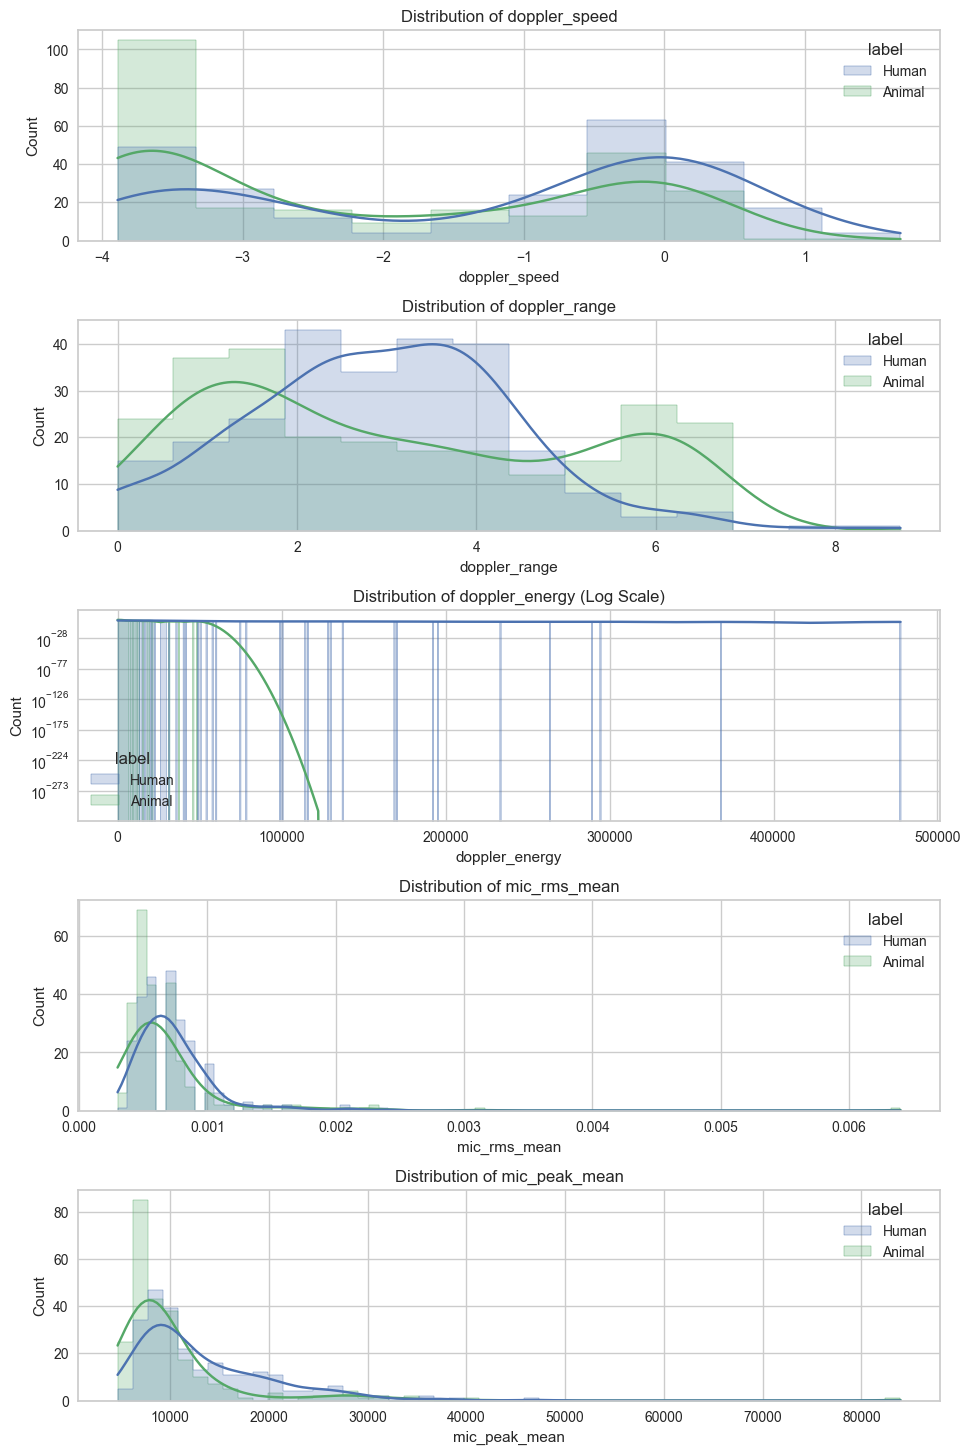

In [21]:
if 'viz_df' in locals():
    # Plot key sensor distributions
    key_features = ['doppler_speed', 'doppler_range', 'doppler_energy', 'mic_rms_mean', 'mic_peak_mean']
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(nrows=len(key_features), ncols=1, figsize=(10, 15))
    fig.tight_layout(pad=3.0)

    for i, feature in enumerate(key_features):
        sns.histplot(data=viz_df, x=feature, hue='label', kde=True, ax=axes[i], element="step", palette=['#4c72b0', '#55a868'])
        axes[i].set_title(f'Distribution of {feature}')
        # Handle log scale for energy, as it often has a large range
        if feature == 'doppler_energy':
            axes[i].set_yscale('log')
            axes[i].set_title(f'Distribution of {feature} (Log Scale)')

    plt.show()
else:
    print("viz_df not created. Cannot plot distributions.")

### Advanced Visualization: Thermal & Mic Samples

Let's look at the array data. We can create an "average thermal image" for humans and animals by averaging all 64 thermal pixels. We can also plot the `rms_samples` for a few examples.

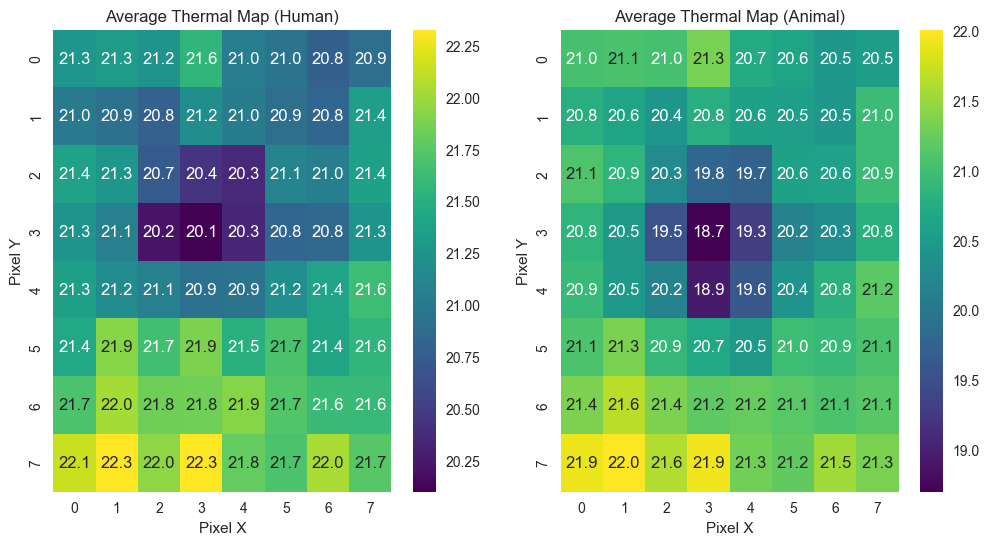

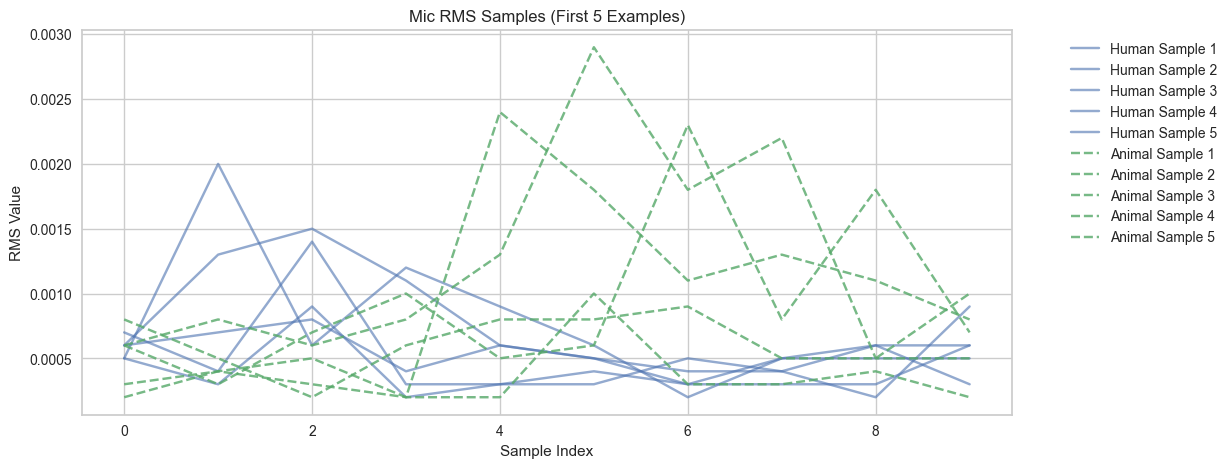

In [22]:
if all_data:
    # 1. Average Thermal Heatmaps
    human_thermal = np.array([s['thermal'] for s in all_data if s['label'] == 0 and len(s['thermal']) == 64])
    animal_thermal = np.array([s['thermal'] for s in all_data if s['label'] == 1 and len(s['thermal']) == 64])

    if human_thermal.size > 0 and animal_thermal.size > 0:
        avg_human_thermal = np.mean(human_thermal, axis=0).reshape(8, 8)
        avg_animal_thermal = np.mean(animal_thermal, axis=0).reshape(8, 8)

        # Plotting
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        
        sns.heatmap(avg_human_thermal, ax=ax1, cmap='viridis', annot=True, fmt=".1f")
        ax1.set_title('Average Thermal Map (Human)')
        ax1.set_xlabel('Pixel X')
        ax1.set_ylabel('Pixel Y')
        
        sns.heatmap(avg_animal_thermal, ax=ax2, cmap='viridis', annot=True, fmt=".1f")
        ax2.set_title('Average Thermal Map (Animal)')
        ax2.set_xlabel('Pixel X')
        ax2.set_ylabel('Pixel Y')
        
        plt.show()
    else:
        print("Not enough thermal data to generate average heatmaps.")

    # 2. Plot Mic RMS Samples for first 5 of each class
    human_mic_samples = [s['mic']['rms_samples'] for s in all_data if s['label'] == 0 and len(s['mic']['rms_samples']) == 10][:5]
    animal_mic_samples = [s['mic']['rms_samples'] for s in all_data if s['label'] == 1 and len(s['mic']['rms_samples']) == 10][:5]

    plt.figure(figsize=(12, 5))
    for i, sample in enumerate(human_mic_samples):
        plt.plot(sample, label=f'Human Sample {i+1}', color='#4c72b0', alpha=0.6)
    for i, sample in enumerate(animal_mic_samples):
        plt.plot(sample, label=f'Animal Sample {i+1}', color='#55a868', linestyle='--', alpha=0.8)

    plt.title('Mic RMS Samples (First 5 Examples)')
    plt.xlabel('Sample Index')
    plt.ylabel('RMS Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [ ]:
# create a gif from animal dataset

import imageio
import numpy as np
import os
import matplotlib.pyplot as plt

# Directory containing animal thermal data files
data_dir = '../data/animal_thermal/'
output_gif = 'animal_thermal_animation.gif'




FileNotFoundError: [Errno 2] No such file or directory: '../data/animal_thermal_images/'

### Visualization Insights

From these plots, we can already see some clear differences:
* **Class Imbalance:** We have more human samples than animal samples. We'll need to account for this (e.g., using `stratify` in our train/test split and `class_weight='balanced'` in the model).
* **Doppler Energy:** This looks like a *very* strong predictor. The distributions for humans and animals seem to be quite different, with humans often showing much higher energy spikes.
* **Mic Peak Mean:** This also shows some separation, with humans (label 0) having more high-peak events.
* **Thermal Maps:** The average thermal maps might show if one class consistently appears "hotter" in a specific area of the sensor.

This confirms our statistical features (`mean`, `std`, etc.) are a good idea. Now, we can proceed with feature engineering, confident in *why* we're choosing those features.

## Step 3: Feature Engineering


This is a critical step. Our first analysis (in Step 2.5) showed that just using `mean`, `std`, `min`, and `max` of the thermal array might not be enough, as it ignores the 8x8 spatial structure of the image.

Here, we will extract much more powerful features from the thermal image, in addition to our other sensor data.

* **Doppler & Mic:** Same as before.
* **Mic (Samples):** `mean`, `std`, `min`, `max` (statistical features).
* **Thermal (Basic Stats):** `mean`, `std`, `min`, `max` (still useful).
* **Thermal (Advanced Spatial Features):**
    * **Centroid (X, Y):** We'll find the "center of mass" of the heat. This gives us an (x, y) coordinate of *where* the object is in the frame.
    * **Vertical/Horizontal Difference:** We'll compare the average heat of the top half vs. the bottom half, and the left half vs. the right half. This helps capture the "shape" (e.g., a "tall" human vs. a "low" animal).

In [7]:
# Create coordinate grids that we only need to calculate once
# y_coords (0-7, rows), x_coords (0-7, cols)
y_coords, x_coords = np.indices((8, 8))

def extract_features(sample):
    """Converts a single JSON sample into a flat feature dictionary."""
    features = {}
    
    # Label (our target)
    features['label'] = sample['label']
    
    # --- Doppler features ---
    features['doppler_speed'] = sample['doppler']['speed']
    features['doppler_range'] = sample['doppler']['range']
    features['doppler_energy'] = sample['doppler']['energy']
    
    # --- Mic features ---
    features['mic_rms_mean'] = sample['mic']['rms_mean']
    features['mic_peak_mean'] = sample['mic']['peak_mean']
    
    # --- Mic RMS samples features ---
    rms_samples = np.array(sample['mic']['rms_samples'])
    if len(rms_samples) > 0:
        features['mic_rms_samples_mean'] = np.mean(rms_samples)
        features['mic_rms_samples_std'] = np.std(rms_samples)
        features['mic_rms_samples_min'] = np.min(rms_samples)
        features['mic_rms_samples_max'] = np.max(rms_samples)
    else:
        features['mic_rms_samples_mean'] = 0
        features['mic_rms_samples_std'] = 0
        features['mic_rms_samples_min'] = 0
        features['mic_rms_samples_max'] = 0
    
    # --- Thermal features ---
    thermal = np.array(sample['thermal'])
    if len(thermal) == 64:  # Ensure it's a valid 8x8 grid
        # 1. Basic Stats (still good to have)
        features['thermal_mean'] = np.mean(thermal)
        features['thermal_std'] = np.std(thermal)
        features['thermal_min'] = np.min(thermal)
        features['thermal_max'] = np.max(thermal)
        
        # Reshape to 8x8 image
        image = thermal.reshape(8, 8)
        
        # 2. Advanced Spatial Features
        
        # -- Centroid (Center of Mass) --
        # We use (temp - min_temp) as the "weight" for each pixel
        weights = image - features['thermal_min']
        total_weight = np.sum(weights)
        
        if total_weight > 0:
            # Find the weighted average of the x and y coordinates
            features['thermal_centroid_y'] = np.sum(weights * y_coords) / total_weight
            features['thermal_centroid_x'] = np.sum(weights * x_coords) / total_weight
        else:
            # If no heat (all pixels are min), place centroid in the middle
            features['thermal_centroid_y'] = 3.5 
            features['thermal_centroid_x'] = 3.5

        # -- Half-Image Comparisons (Shape) --
        top_half_mean = np.mean(image[0:4, :])
        bottom_half_mean = np.mean(image[4:8, :])
        left_half_mean = np.mean(image[:, 0:4])
        right_half_mean = np.mean(image[:, 4:8])
        
        features['thermal_vertical_diff'] = top_half_mean - bottom_half_mean
        features['thermal_horizontal_diff'] = left_half_mean - right_half_mean

    else:
        # Add default values if thermal data is missing or invalid
        features['thermal_mean'] = 0
        features['thermal_std'] = 0
        features['thermal_min'] = 0
        features['thermal_max'] = 0
        features['thermal_centroid_y'] = 3.5
        features['thermal_centroid_x'] = 3.5
        features['thermal_vertical_diff'] = 0
        features['thermal_horizontal_diff'] = 0
    
    return features

In [8]:
if all_data:
    feature_list = [extract_features(sample) for sample in all_data]
    
    # Create a Pandas DataFrame
    df = pd.DataFrame(feature_list)
    print("Advanced feature extraction complete.")
    print(f"DataFrame shape: {df.shape}")
    display(df.head())
else:
    print("Cannot proceed with feature extraction: No data loaded.")

Advanced feature extraction complete.
DataFrame shape: (500, 18)


,label,doppler_speed,doppler_range,doppler_energy,mic_rms_mean,mic_peak_mean,mic_rms_samples_mean,mic_rms_samples_std,mic_rms_samples_min,mic_rms_samples_max,thermal_mean,thermal_std,thermal_min,thermal_max,thermal_centroid_y,thermal_centroid_x,thermal_vertical_diff,thermal_horizontal_diff
0,0,0.00,0.00,0.0,0.0007,9504,0.00074,0.000498,0.0002,0.0020,21.289062,0.599835,20.00,22.75,4.081818,3.306061,-0.671875,0.406250
1,0,-0.16,2.65,1129.0,0.0005,8161,0.00056,0.000128,0.0004,0.0008,21.308594,0.592502,19.50,23.00,3.902808,3.403888,-0.679688,0.289062
2,0,-3.84,3.73,170.0,0.0004,6354,0.00041,0.000197,0.0002,0.0009,21.289062,0.603082,19.75,23.25,3.901015,3.370558,-0.640625,0.343750
3,0,-3.75,6.28,145.0,0.0005,7033,0.00054,0.000350,0.0002,0.0014,21.253906,0.638131,19.75,23.25,3.935065,3.348052,-0.695312,0.320312
4,0,-3.74,3.49,205.0,0.0007,18028,0.00074,0.000385,0.0003,0.0015,21.128906,0.594559,19.75,23.00,4.036827,3.365439,-0.742188,0.304688


## Step 4: Model Exploration with PyCaret

Now that we have a strong `df` with our advanced features, we'll use PyCaret to do a "bake-off" of all the models that are simple enough to *potentially* run on a microcontroller. This saves us a ton of time.

We will **NOT** use `compare_models()` on everything, as it would pick a large model like `RandomForest`. Instead, we will `include` *only* the simple models.

**ESP32-Friendly Models to Test:**
* `lr`: Logistic Regression
* `dt`: Decision Tree (a single, shallow tree is very fast)
* `nb`: Naive Bayes
* `svm`: Support Vector Machine (a linear one is simple)
* `ridge`: Ridge Classifier

In [9]:
from pycaret.classification import *

if 'df' in locals():
    # Setup PyCaret environment
    # This will:
    # 1. Create a train/test split (80/20)
    # 2. Automatically scale our features (using 'zscore')
    # 3. Stratify the split to handle our imbalanced data
    
    clf_setup = setup(
        data=df,
        target='label',
        session_id=123,          # For reproducibility
        normalize=True,          # Replaces our StandardScaler
        normalize_method='zscore',
        train_size=0.8,
        html=False               # Avoids rich output in some environments
    )
    
    print("PyCaret setup complete.")
else:
    print("DataFrame 'df' not found. Please re-run Step 3.")

                    Description             Value
0                    Session id               123
1                        Target             label
2                   Target type            Binary
3           Original data shape         (500, 18)
4        Transformed data shape         (500, 18)
5   Transformed train set shape         (400, 18)
6    Transformed test set shape         (100, 18)
7              Numeric features                17
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12                    Normalize              True
13             Normalize method            zscore
14               Fold Generator   StratifiedKFold
15                  Fold Number                10
16                     CPU Jobs                -1
17                      Use GPU             False
18               Log Experiment             False


## Step 5: Compare Lightweight Models

Here's the power of PyCaret. We'll tell it to train, test, and cross-validate *only* our list of simple models and rank them for us.

In [10]:
# Define our whitelist of lightweight, microcontroller-friendly models
lightweight_models = ['lr', 'nb', 'dt', 'svm', 'ridge']

# Run the model comparison
print("Comparing lightweight models...")
best_light_model_comparator = compare_models(
    include=lightweight_models,
    sort='Accuracy'  # Rank them by Accuracy
)

print("\nPyCaret Lightweight Model Comparison Results:")
display(best_light_model_comparator)

Comparing lightweight models...


                          Model  Accuracy     AUC  Recall   Prec.      F1  \
nb                  Naive Bayes    0.8650  0.9097   0.960  0.8140  0.8786   
lr          Logistic Regression    0.8600  0.9118   0.905  0.8367  0.8668   
dt     Decision Tree Classifier    0.8575  0.8575   0.845  0.8720  0.8557   
ridge          Ridge Classifier    0.8275  0.9018   0.940  0.7751  0.8474   
svm         SVM - Linear Kernel    0.8075  0.8795   0.790  0.8227  0.7981   

       Kappa     MCC  TT (Sec)  
nb     0.730  0.7481     0.005  
lr     0.720  0.7277     0.413  
dt     0.715  0.7196     0.007  
ridge  0.655  0.6751     0.005  
svm    0.615  0.6241     0.005  

PyCaret Lightweight Model Comparison Results:


GaussianNB(priors=None, var_smoothing=1e-09)

## Step 6: Analyze PyCaret Results

The grid above tells us which *type* of simple model performs best on our engineered features. It's very likely `Logistic Regression` (`lr`) or a `Support Vector Machine` (`svm`) did well.

This gives us **confidence** that a simple *linear* model or a simple *neural network* can solve this problem. We don't need a giant, complex model.

For the ESP32, the **best path is TensorFlow Lite for Microcontrollers (TFLuM)**. We will now build a simple Keras Neural Network (which is similar in complexity to Logistic Regression) and convert it for our ESP32.

## Step 7: Build and Train a TensorFlow/Keras Model for TFLite

We will now build a *very small* neural network. This is the model we will actually convert and deploy.

* **Inputs:** Our 16 engineered features.
* **Hidden Layers:** Two tiny hidden layers (e.g., 16 and 8 neurons) with `relu` activation.
* **Output Layer:** A single neuron with `sigmoid` activation (for 0 or 1).

Building Keras model with 17 input features.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 17)             │            68 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,461 (44.77 KB)

 Trainable params: 11,043 (43.14 KB)

 Non-trainable params: 418 (1.63 KB)


Training the Keras model...
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5413 - auc: 0.5523 - loss: 0.8536 - val_accuracy: 0.8500 - val_auc: 0.9250 - val_loss: 0.5804 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7949 - auc: 0.8749 - loss: 0.4579 - val_accuracy: 0.8700 - val_auc: 0.9540 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8266 - auc: 0.8927 - loss: 0.4391 - val_accuracy: 0.8800 - val_auc: 0.9646 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - auc: 0.8805 - loss: 0.4645 - val_accuracy: 0.9000 - val_auc: 0.9690 - val_loss: 0.4421 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8404 - auc: 0.9047 - loss: 0.4122 - val_accuracy: 0.9200 - val_auc: 0.9744 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

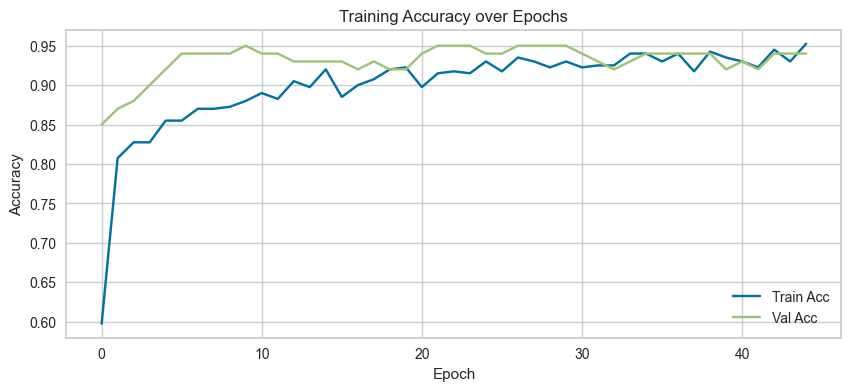

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# Reproducibility
tf.random.set_seed(42)

# Get preprocessed data from PyCaret
X_train = get_config('X_train_transformed')
y_train = get_config('y_train')
X_test = get_config('X_test_transformed')
y_test = get_config('y_test')

n_features = X_train.shape[1]
print(f"Building Keras model with {n_features} input features.")

# Model architecture
model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    
    # Batch normalization first — helps stabilize gradients
    layers.BatchNormalization(),
    
    # Dense block 1
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    # Dense block 2
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Output layer for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

model.summary()

# Callbacks for better training control
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Training
print("\nTraining the Keras model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nKeras model training complete.")

# Evaluate
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"\nFinal Model Performance on Test Data:")
print(f"  Accuracy: {accuracy * 100:.2f}%")
print(f"  AUC: {auc:.3f}")
print(f"  Loss: {loss:.4f}")

# Optionally visualize training
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import numpy as np
np.bincount(y_train)


array([200, 200])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


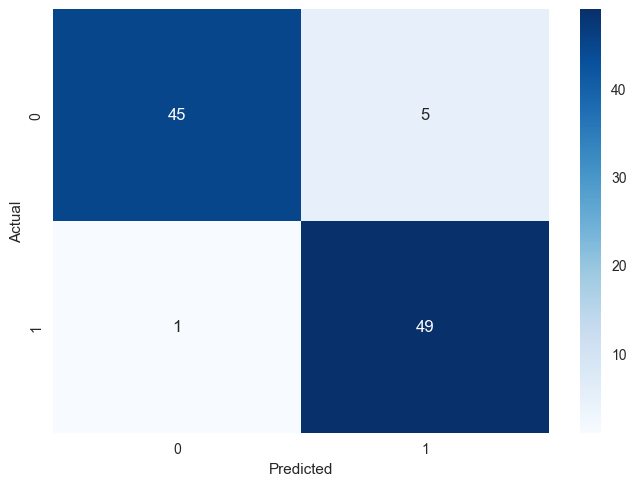

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        50
           1       0.91      0.98      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred))

## Step 8: Convert to TFLite and Quantize (The ESP32 Step)

This is the most important step for the ESP32. We will:
1.  Convert the Keras model to a TensorFlow Lite model.
2.  Apply **Full Integer 8-bit Quantization (INT8)**. This makes the model *dramatically* smaller and faster, which is required for microcontrollers.
3.  To do this, we must provide a "representative dataset" so the converter knows the range of our input data.

In [14]:
print("Converting Keras model to TensorFlow Lite...")

# 1. Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

X_train_scaled = get_config('X_train_transformed')

# 2. Define the representative dataset (for quantization)
# This function feeds a few samples of our *scaled training data* to the converter.
def representative_dataset_gen():
    # Use 100 samples from the scaled training data
    for i in range(100):
        # The data must be in the correct tensor shape and type
        yield [X_train_scaled.iloc[[i]].to_numpy().astype(np.float32)]

# 3. Set the converter flags for INT8 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Input will be 8-bit int
converter.inference_output_type = tf.int8 # Output will be 8-bit int

# 4. Convert the model!
tflite_quant_model = converter.convert()

# 5. Save the quantized model to a file
model_filename = 'movement_model.tflite'
with open(model_filename, 'wb') as f:
    f.write(tflite_quant_model)

print(f"Quantized TFLite model saved as: {model_filename}")
print(f"Original model size (approx): {len(model.to_json())} bytes")
print(f"Quantized model size: {len(tflite_quant_model)} bytes")

Converting Keras model to TensorFlow Lite...
INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmp0rehk4ml/assets


INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmp0rehk4ml/assets


Saved artifact at '/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmp0rehk4ml'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 17), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5545956800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545957680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545956272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545956448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545959264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545958560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546032112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546090560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546031232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546031936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546091968: TensorSpec(shape=

W0000 00:00:1761786336.573663 3163276 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1761786336.573677 3163276 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-10-29 21:05:36.574059: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmp0rehk4ml
2025-10-29 21:05:36.574569: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-29 21:05:36.574574: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmp0rehk4ml
I0000 00:00:1761786336.578152 3163276 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-10-29 21:05:36.578788: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-29 21:05:36.605605: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

## Step 9: Convert TFLite Model to C Array for ESP32

The ESP32 project (Arduino or ESP-IDF) can't read a `.tflite` file directly. You must compile the model *into* your firmware as a C array.

We can use the `xxd` command (available on Linux/macOS) to do this automatically. If you're on Windows, you can use an online converter or `wsl` (Windows Subsystem for Linux).

In [15]:
# Use the 'xxd' tool to convert the file to a C array
# This creates a file named 'model_data.h'
!echo "const unsigned char model[] = {" > model_data.h
!xxd -i movement_model.tflite >> model_data.h
!echo "};" >> model_data.h

print("Created 'model_data.h' file.")
print("\n--- First 10 lines of 'model_data.h' ---")
!head -n 10 model_data.h
print("------------------------------------------")

Created 'model_data.h' file.

--- First 10 lines of 'model_data.h' ---
const unsigned char model[] = {
unsigned char movement_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00,
  0xd0, 0x2d, 0x00, 0x00, 0xe0, 0x2d, 0x00, 0x00, 0xc0, 0x47, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xe2, 0xd1, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
------------------------------------------


## Final Workflow and Deployment

You have successfully:
1.  Engineered advanced spatial and statistical features from your sensors.
2.  Used PyCaret to *prove* that a simple, lightweight model can effectively classify the data.
3.  Built a tiny, efficient neural network using TensorFlow/Keras.
4.  Converted and quantized this model into an ESP32-ready TFLite file (`movement_model.tflite`).
5.  Exported the model into a C array file (`model_data.h`).

**Your Next Steps for the ESP32:**
1.  Copy the contents of `model_data.h` into a new `.h` file in your Arduino or ESP-IDF project.
2.  Use the `TensorFlowLite_ESP32` library.
3.  In your C++ code, you will:
    * Load the model from the C array.
    * Create the TFLite interpreter.
    * Get your *live* sensor data (from Doppler, Mic, Thermal).
    * **Crucially:** You must perform the **exact same feature engineering** on the ESP32. This includes calculating the `thermal_centroid_y`, `thermal_vertical_diff`, etc.
    * **You must also scale your features** using the *mean* and *standard deviation* from the training data. You'll need to save these scaling values from the `StandardScaler` in PyCaret (`get_config('prep_pipe')`) and hard-code them into your C++ file.
    * Quantize your input data to `int8`.
    * Run `interpreter->Invoke()`.
    * De-quantize the `int8` output to get your 0-1 probability.

In [16]:
import tensorflow as tf
import numpy as np
import os

print("🔄 Converting Keras model to TensorFlow Lite (INT8 for ESP32)...")

# 1️⃣ Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2️⃣ Define the representative dataset
def representative_dataset_gen():
    n_samples = min(100, len(X_train_scaled))
    for i in range(n_samples):
        sample = X_train_scaled.iloc[[i]].to_numpy().astype(np.float32)
        yield [sample]

# 3️⃣ Set converter flags for full INT8 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# 4️⃣ Convert the model
try:
    tflite_quant_model = converter.convert()
    print("✅ Conversion successful.")
except Exception as e:
    raise RuntimeError(f"❌ TFLite conversion failed: {e}")

# 5️⃣ Save quantized model
model_filename = "movement_model_int8.tflite"
with open(model_filename, "wb") as f:
    f.write(tflite_quant_model)

# Compute and show sizes
keras_size_kb = os.path.getsize(model_filename) / 1024
print(f"💾 Quantized model saved: {model_filename}")
print(f"📏 Quantized model size: {keras_size_kb:.1f} KB")

# Optional: Compare with a float model
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_model = float_converter.convert()
float_size_kb = len(float_model) / 1024
print(f"📉 Size reduction: {(1 - keras_size_kb / float_size_kb) * 100:.1f}% smaller than float32")

# 6️⃣ Convert to C array (for ESP32 firmware)
header_filename = "model_movement.h"
print(f"\n🔧 Converting to C array ({header_filename})...")

with open(header_filename, "w") as f:
    f.write("#ifndef MODEL_MOVEMENT_H\n")
    f.write("#define MODEL_MOVEMENT_H\n\n")
    f.write("#include <stdint.h>\n\n")
    f.write(f"const unsigned char model[] = {{\n")

    # Write bytes as 0xXX, 12 per line
    for i, byte in enumerate(tflite_quant_model):
        if i % 12 == 0:
            f.write("  ")
        f.write(f"0x{byte:02x}, ")
        if i % 12 == 11:
            f.write("\n")

    f.write("\n};\n\n")
    f.write(f"const unsigned int model_len = {len(tflite_quant_model)};\n\n")
    f.write("#endif // MODEL_MOVEMENT_H\n")

# 7️⃣ Sanity check
if os.path.exists(header_filename):
    print(f"✅ Created '{header_filename}' successfully.")
    print("\n--- First 10 lines of model_movement.h ---")
    with open(header_filename, "r") as f:
        for _ in range(10):
            print(f.readline().rstrip())
    print("---------------------------------------")
else:
    raise FileNotFoundError(f"❌ {header_filename} was not created properly.")


🔄 Converting Keras model to TensorFlow Lite (INT8 for ESP32)...
INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpz9rqhvoy/assets


INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpz9rqhvoy/assets


Saved artifact at '/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpz9rqhvoy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 17), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5545956800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545957680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545956272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545956448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545959264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545958560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546032112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546090560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546031232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546031936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546091968: TensorSpec(shape=

W0000 00:00:1761786338.479693 3163276 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1761786338.479706 3163276 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-10-29 21:05:38.479818: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpz9rqhvoy
2025-10-29 21:05:38.480322: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-29 21:05:38.480328: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpz9rqhvoy
2025-10-29 21:05:38.484668: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-29 21:05:38.512808: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpz9rqhvoy
2025-10-29 21:05:38.521646: I tensorflow/cc/saved_model/loader.cc:

✅ Conversion successful.
💾 Quantized model saved: movement_model_int8.tflite
📏 Quantized model size: 18.0 KB
INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpukygs_b3/assets


INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpukygs_b3/assets


Saved artifact at '/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpukygs_b3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 17), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5545956800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545957680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545956272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545956448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545959264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5545958560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546032112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546090560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546031232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546031936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5546091968: TensorSpec(shape=

W0000 00:00:1761786339.211026 3163276 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1761786339.211036 3163276 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-10-29 21:05:39.211141: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpukygs_b3
2025-10-29 21:05:39.211629: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-29 21:05:39.211634: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpukygs_b3
2025-10-29 21:05:39.215597: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-29 21:05:39.238205: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpukygs_b3
2025-10-29 21:05:39.244961: I tensorflow/cc/saved_model/loader.cc: